In [1]:
# Importing packages

# 📦 Standard Library
from pathlib import Path
import pandas as pd
import numpy  as np
from sklearn.cluster import KMeans
import seaborn as sns
import chardet

from pollutant_predictor.data.make_dataset import load_obd, load_datasets
from pollutant_predictor.config.paths import RAW_DIR, INTERIM_DIR, PROCESSED_DIR

Understanding Building Circularity
When working with these datasets, consider these key circularity concepts:

Material Connections: How materials are joined affects their potential for disassembly

- Mechanical connections (screws, bolts) typically allow easier separation
- Chemical connections (adhesives, mortars) may hinder material recovery
- Connection design directly impacts end-of-life reusability

End-of-Life Scenarios: Different materials have different potential pathways

Reuse: Direct application in new construction (highest value retention)
Recycling: Processing into new material (partial value retention)
Downcycling: Processing into lower-value applications
Disposal: Landfilling or incineration (lowest circularity value)
Environmental Indicators: Key metrics to consider include

Global Warming Potential (GWP)

# Goal 1: Automating Pollutant Assessment 
Current Situation: 
- ​To evaluate a material's reusability, users must manually input information about 
pollutants 
- ​These pollutants (adhesives, paints, fire retardants, etc.) affect how easily materials can 
be separated and reused 
- ​The manual nature of this process introduces inconsistency and inefficiency 



## Objective: Develop a system that automatically suggests strong default pollutant values based on the materials being assessed. 
This system should: 
- ​Predict likely pollutants based on material combinations 
- Provide appropriate pollutant classifications 
- Reduce manual input while improving assessment accuracy 

Analyzing material combinations in building components
Identifying connection types that support circular construction
Suggesting intuitive default connections between materials
Classifying connection types according to pollution potential

## Methodology and approach
- Machine learning models to predict pollutants based on material combinations 
- Pattern recognition systems that identify common construction methods and associated 
pollutants 
- Rule-based systems derived from expert knowledge 
- ​Default value frameworks with adjustment mechanisms based on material properties 

## Guiding Questions

1. How can we identify which materials are commonly used together in building components?
2. What properties in the datasets can help us determine the type of connections used between materials?
3. How might different connection types affect the end-of-life scenarios in the tBaustoff dataset?
4. Can we classify connections based on their environmental impact using the lifecycle assessment data?
5. What metrics could we use to define the "disturbance potential" of different connection types?
6. How can we develop a recommendation system for material connections that optimizes for circularity?

## to have in mind

When working with these datasets, consider these key circularity concepts:

Material Connections: How materials are joined affects their potential for disassembly 
- Mechanical connections (screws, bolts) typically allow easier separation
- Chemical connections (adhesives, mortars) may hinder material recovery
- Connection design directly impacts end-of-life reusability

End-of-Life Scenarios: Different materials have different potential pathways

- Reuse: Direct application in new construction (highest value retention)
- Recycling: Processing into new material (partial value retention)
- Downcycling: Processing into lower-value applications
- Disposal: Landfilling or incineration (lowest circularity value)


# Data Wrangling

Notes on ÖKOBAUDAT Data:

Each dataset contains environmental impact indicators organized by lifecycle phases
Material entries include detailed technical specifications and reference quantities
Data follows standardized categories based on international norms (EN 15804)
UUID identifiers ensure consistent referencing across different datasets

The database follows the European Standard EN 15804+A2 for sustainable building assessment, which is additionally reflected in the column names of the Environmental Impact Indicators (`(A2)` postfix in the column name). Impact values can be positive (environmental burden) or negative (environmental credit).

The [`ÖKOBAUDAT`](https://www.oekobaudat.de/en.html) is Germany's standardized database for ecological evaluations of buildings by the [Federal Ministry for Housing, Urban Development and Building (BMWSB)](https://www.bmwsb.bund.de/Webs/BMWSB/DE/startseite/startseite-node.html). At its core lies the life cycle assessment (LCA) data on building materials, construction, transport, energy and disposal processes. 

Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. If you see a reference to a *Process* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

The dataset contains multiple rows for the same material. To understand why there are duplicates, let's pay attention to the ``Modul`` column -- it indicates the lifecycle stage of the material. So, each dataset represents environmental impacts across different life cycle stages:


- **A**: production, transport and installation phase
- **B**: use phase
- **C**: deconstruction and disposal phase    
- **D**: recycling potential and benefits

and the environmental impact of the material varies from one stage to another. The technology description on the website contains more contextual information.

![Copper sheet lifecycle](img/copper_tech_description.png)

Unfortunately, it also looks like a lot of the data is still missing (``NaN``'s in the dataframe). However, the amount of data varies from one material to another. You also won't need all the data for the challenge. We'll select the columns that are most relevant; however, feel free to explore the data further.

## Data Extraction

In [2]:
# Load the datasets
oko_2024_df = load_obd(RAW_DIR / "OBD_2024_I.csv")
oko_2023_df = load_obd(RAW_DIR / "OBD_2023_I.csv")
oko_2020_df = load_obd(RAW_DIR / "OBD_2020_II.csv")
pollutants_df = load_datasets(RAW_DIR / "pollutant_combinations.csv")

In [3]:
# Assesing if to merge the dataframes or just keep the one from 2024

# Compare unique material names between datasets
materials_2020 = set(oko_2020_df["Name (en)"].dropna().unique())
materials_2023 = set(oko_2023_df["Name (en)"].dropna().unique())
materials_2024 = set(oko_2024_df["Name (en)"].dropna().unique())

# Find materials in 2020 and 2023 that are not in 2024
unique_2020 = materials_2020 - materials_2024
unique_2023 = materials_2023 - materials_2024

# Count them
unique_2020_count = len(unique_2020)
unique_2023_count = len(unique_2023)

unique_2020_count, unique_2023_count


(262, 546)

There are materials in previous datasets that are not present in the 2024 dataset:

- 2020 has 262 materials not found in 2024.
- 2023 has 546 materials not found in 2024.

This means that the 2024 dataset is not a full replacement — it doesn’t include all materials from earlier versions.

For maximum coverage (e.g. all materials ever documented), we should consider including previous years.

In [4]:
# merging the datasets

# Add a source column for reference
oko_2020_df["source_year"] = 2020
oko_2023_df["source_year"] = 2023
oko_2024_df["source_year"] = 2024

# Combine all datasets
oko_combined_df = pd.concat([oko_2020_df, oko_2023_df, oko_2024_df], ignore_index=True)

In [5]:
# Sort by source year descending to keep the latest entry in case of duplicates
combined_df_sorted = oko_combined_df.sort_values(by="source_year", ascending=False)

# Drop duplicates keeping the latest version (based on UUID, Version, Modul)
deduped_df = combined_df_sorted.drop_duplicates(subset=["UUID", "Version", "Modul"], keep="first") # could think of replace "UUID with "Name (de)" or "Name (en)" to keep the latest version of the name

# Reset index and show result
deduped_df.reset_index(drop=True, inplace=True)

## Data Cleaning

In [6]:
# Identifying the columns with missing values
missing_values = deduped_df.isnull().sum()
missing_values

UUID                        0
Version                     0
Name (de)                2886
Name (en)                2953
Kategorie (original)        0
                        ...  
WDP (A2)                 9405
Unnamed: 79             25665
source_year                 0
Stueckgewicht (kg)      25477
Unnamed: 80             25665
Length: 83, dtype: int64

In [7]:
# Calculate percentage of missing values per column
null_percentage = deduped_df.isnull().mean().sort_values(ascending=False)

# Select columns with more than 90% missing values
high_null_cols = null_percentage[null_percentage > 0.9]
high_null_cols

URL des Vorgängers        1.000000
Unnamed: 80               1.000000
Unnamed: 79               1.000000
Stueckgewicht (kg)        0.992675
Ergiebigkeit (m2)         0.987064
Schuettdichte (kg/m3)     0.986090
Laengengewicht (kg/m)     0.941126
Version des Vorgängers    0.937502
dtype: float64

These columns have extremely low data coverage and are unlikely to offer analytical value without substantial data imputation or external sourcing. Dropping them will simplify the dataset and reduce noise without significant information loss.

Unnamed: 80 and URL des Vorgängers are completely empty → should be dropped.


In [8]:
# Drop the columns with >90% missing values
columns_to_drop = [
    "Unnamed: 80", "Unnamed: 79", "URL des Vorgängers",
    "Stueckgewicht (kg)", "Ergiebigkeit (m2)", "Schuettdichte (kg/m3)",
    "Laengengewicht (kg/m)", "Version des Vorgängers"
]

cleaned_df = deduped_df.drop(columns=columns_to_drop)

Missing values of Environmental Impact Indicators (EN 15804+A1 and +2)

Understanding the EN 15804 Standard and Its Impact on LCA Calculations
The EN 15804 standard is the foundation for Environmental Product Declarations (EPDs) worldwide. In 2019, a significant update (EN 15804+A2) was released, becoming mandatory in July 2022. This update changes how environmental impacts are measured in EPDs.

What Changed?
While the environmental impact categories (like global warming and ozone depletion) are mostly the same, the units used to measure them have changed. This means that older EPDs (EN 15804+A1) cannot be directly compared or used with newer EPDs (EN 15804+A2) in LCA calculations.

How does this affect Building LCA?
Simply put, you can't mix and match old and new EPDs in your building LCA calculations.

Since 15804+A1 has a big % of missing values and it's out of use, I will evaluate drop the whole columns unless they have values that are not covered in +A2



In [9]:
# Define A1 and A2 column groups
a1_columns = ["GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF"]
a2_columns = [
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
    "ODP (A2)", "POCP (A2)", "AP (A2)", "EPmarine (A2)", "EPfreshwater (A2)", 
    "EPterrestrial (A2)", "ADPE (A2)", "ADPF (A2)"
]

# Check for non-null rows in A1 indicators
a1_non_null = (cleaned_df[a1_columns].notnull().sum()).sort_values(ascending=False)

# Check for any A1 values that do not have A2 counterparts in the same row
# Simplest heuristic: check if A1 column is filled but all A2s are null for that row
rows_with_only_a1 = cleaned_df[a1_columns].notnull().any(axis=1) & (~cleaned_df[a2_columns].notnull().any(axis=1))

# Count how many rows this applies to
only_a1_count = rows_with_only_a1.sum()

a1_non_null, only_a1_count


(GWP     8294
 ODP     8281
 POCP    8281
 AP      8281
 ADPE    8281
 EP      8279
 ADPF    8277
 dtype: int64,
 np.int64(8294))

Interpretation: These A1 values are not duplicated or represented in the A2 columns — they are unique to older datasets.
Therefore, dropping them would result in data loss for ~8,300 records.

## Data Transformation

In [10]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 75 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   UUID                                           25665 non-null  object 
 1   Version                                        25665 non-null  object 
 2   Name (de)                                      22779 non-null  object 
 3   Name (en)                                      22712 non-null  object 
 4   Kategorie (original)                           25665 non-null  object 
 5   Kategorie (en)                                 25665 non-null  object 
 6   Konformität                                    25665 non-null  object 
 7   Laenderkennung                                 25659 non-null  object 
 8   Typ                                            25665 non-null  object 
 9   Referenzjahr                                   256

In [11]:
# Convert numeric columns (A2 environmental indicators and other relevant ones) from string to float
# We'll replace commas with dots and coerce errors to NaN

numeric_cols = [
    "Referenzjahr", "Gueltig bis","Bezugsgroesse", "Bezugseinheit ","Rohdichte (kg/m3)","Flaechengewicht (kg/m2)","Schichtdicke (m)", "Umrechungsfaktor auf 1kg","biogener Kohlenstoffgehalt in kg","biogener Kohlenstoffgehalt (Verpackung) in kg","GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF","PERE", "PERM", "PERT", "PENRE", "PENRM", "PENRT",
    "SM", "RSF", "NRSF", "FW", "HWD", "NHWD", "RWD", "CRU", "MFR", "MER", "EEE", "EET",
    "AP (A2)", "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
    "ETPfw (A2)", "PM (A2)", "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
    "HTPc (A2)", "HTPnc (A2)", "IRP (A2)", "SOP (A2)", "ODP (A2)", "POCP (A2)",
    "ADPF (A2)", "ADPE (A2)", "WDP (A2)"
]

# Convert all columns listed above 
for col in numeric_cols:
    if col in cleaned_df.columns:
        cleaned_df[col] = cleaned_df[col].astype(str).str.replace(",", ".").str.strip()
        cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')

# Convert date column to datetime
if "Veroeffentlicht am" in cleaned_df.columns:
    cleaned_df["Veroeffentlicht am"] = pd.to_datetime(cleaned_df["Veroeffentlicht am"], errors='coerce')

# Convert Referenzjahr and Gueltig bis to integer 
cleaned_df["Referenzjahr"] = cleaned_df["Referenzjahr"].dropna().astype("Int64")
cleaned_df["Gueltig bis"] = cleaned_df["Gueltig bis"].dropna().astype("Int64")

- Numeric columns were converted from string (with commas) to proper float types.

- Date column Veroeffentlicht am is now in datetime format.

- Year columns like Referenzjahr and Gueltig bis were converted to integer type where possible.

In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 75 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   UUID                                           25665 non-null  object        
 1   Version                                        25665 non-null  object        
 2   Name (de)                                      22779 non-null  object        
 3   Name (en)                                      22712 non-null  object        
 4   Kategorie (original)                           25665 non-null  object        
 5   Kategorie (en)                                 25665 non-null  object        
 6   Konformität                                    25665 non-null  object        
 7   Laenderkennung                                 25659 non-null  object        
 8   Typ                                            25665 non

#REVIEW - Was thinking of imputing missing values of A2 columns with the median for category and module, but two materials in the same Kategorie (en) and Modul can differ a lot in their environmental impact or circularity, especially depending on:

- Production method (e.g., recycled vs virgin)
- Geographic source (local vs imported)
- Manufacturer-specific practices
- Declared unit or functional equivalence

Let's check if we can impute this values from other sources

## Data Enrichment

In [13]:
# Helper column classifying the environmental impact standard
def classify_impact_standard(row):
    has_a1 = row[a1_columns].notnull().any()
    has_a2 = row[a2_columns].notnull().any()
    if has_a1 and not has_a2:
        return "A1"
    elif has_a2 and not has_a1:
        return "A2"
    elif has_a1 and has_a2:
        return "mixed"
    else:
        return "none"

# Apply the function
cleaned_df["impact_standard"] = cleaned_df.apply(classify_impact_standard, axis=1)

# Show counts for each category
impact_counts = cleaned_df["impact_standard"].value_counts()

impact_counts


impact_standard
A2      16260
A1       8294
none     1111
Name: count, dtype: int64

In [14]:
# importing as csv
cleaned_df.to_csv(INTERIM_DIR / "obd_merged.csv", sep=",", index=False, encoding="utf-8")

### Grouping high cardinality categorical variables

Why Group High-Cardinality Categorical Variables?

- Simplifies the Data
- Some text columns may have hundreds of unique values but little analytical meaning (e.g., slight naming variations).
- Improves Interpretability
- Creating higher-level groupings makes it easier to see patterns (e.g., grouping brands, regions, or dataset types).
- Reduces Noise in Visualizations/Models
- Too many categories can overwhelm bar charts or lead to sparse dummy variables in ML models.

In [15]:
# Filter the DataFrame for object columns
non_numeric = cleaned_df.select_dtypes("object")

# Loop through columns
for x in non_numeric.columns:
    # Print the number of unique values
    print(f"Number of unique values in {x} column: ", non_numeric[x].nunique())

cleaned_df

Number of unique values in UUID column:  3863
Number of unique values in Version column:  118
Number of unique values in Name (de) column:  2459
Number of unique values in Name (en) column:  2495
Number of unique values in Kategorie (original) column:  264
Number of unique values in Kategorie (en) column:  265
Number of unique values in Konformität column:  16
Number of unique values in Laenderkennung column:  42
Number of unique values in Typ column:  5
Number of unique values in URL column:  3984
Number of unique values in Declaration owner column:  439
Number of unique values in Registrierungsnummer column:  1567
Number of unique values in Registrierungsstelle column:  11
Number of unique values in UUID des Vorgängers column:  809
Number of unique values in Bezugseinheit column:  9
Number of unique values in Referenzfluss-UUID column:  2549
Number of unique values in Referenzfluss-Name column:  2280
Number of unique values in Modul column:  18
Number of unique values in Szenario col

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
0,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022,...,NaN,NaN,NaN,-2.549346e-06,-2.049393e-05,-0.462753,-4.342871e-07,-0.000162,2024,A2
1,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,-1.931275e-07,-0.164974,-11.855288,-3.539990e-11,-1.033700e-02,-441.423176,-8.462049e-07,-0.055600,2024,A2
2,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2024,A2
3,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,2.743039e-08,0.238850,16.740538,5.242030e-11,2.433899e-02,24.347930,3.594269e-07,0.219631,2024,A2
4,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022,...,NaN,NaN,NaN,8.308000e-05,3.862000e-11,0.199900,6.946000e-07,0.001645,2024,A2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25660,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25661,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25662,8d06b1df-e898-4009-adee-57ca44aaafcc,00.05.000,BauderTHERMOFOL,BauderTHERMOFOL U / M,'Kunststoffe' / 'Dachbahnen' / 'PVC-Dachbahnen','Plastics' / 'Roofing membranes' / 'PVC sheet','DIN EN 15804' / 'ISO 14025',DE,average dataset,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25663,d4680073-0c9c-40f4-842f-c6830856812c,00.03.000,Betonpflaster- Standardstein grau mit Vorsatz,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


#TODO - create categories for numerical columns



Advantages of Binning A2 Metrics

Simplicity and Interpretability:
Transforming continuous values into categorical bins (low, medium, high) can make it easier to communicate results, especially when discussing environmental impacts with stakeholders who may not be familiar with the detailed numerical scales.

Mitigation of Outliers:
Binning helps by reducing the impact of outliers. This is particularly useful in environmental data, where extreme values may unduly influence the learning process.

Handling Non-Linear Relationships:
If the relationship between your input features and the target pollutant classifications is non-linear, discretizing continuous features can sometimes help the model capture these patterns more effectively, especially with models that perform better with categorical inputs.

How to Determine Binning Thresholds
Official or Domain-Specific Thresholds:
Check if there are established thresholds in environmental impact studies or standards like EN 15804 or related sustainable building guidelines. Although EN 15804+A2 doesn’t always prescribe discrete bins, you might find reference values in literature or national sustainable building frameworks.

Data-Driven Methods:

Quantile-Based Binning:
You could divide your data into bins based on percentiles (for example, using the 33rd and 67th percentiles to create three bins). This approach adapts naturally to the distribution of your data.

Clustering Techniques:
Methods like k-means clustering on each metric can help identify natural groupings in the data, which may correspond to low, medium, and high categories.

Equal-Width Binning:
Dividing the range of values into equal intervals is a simple method, though it might not capture the underlying data distribution as effectively as quantile-based methods.

Expert-Defined Thresholds:
Collaborate with domain experts to set thresholds based on practical experience or guidelines from sustainability frameworks. Their insights can help ensure that the bins are meaningful in the context of environmental impact assessment.

Implementation Considerations
Trial and Validation:
It may be beneficial to experiment with multiple binning strategies and evaluate the performance of your ML model on each. This allows you to find the right balance between granularity and interpretability.

Preservation of Information:
Although binning simplifies the data, it inherently loses some information. Consider whether your downstream model benefits more from a simplified categorical input or if it would perform better with the raw continuous data. You might even consider an ensemble approach where both binned and continuous features are used.

Documentation:
Clearly document the thresholds and the reasoning behind the chosen binning strategy. This not only supports the reproducibility of your work but also adds transparency to your decision-making process in the model development lifecycle.

Conclusion
Yes, binning the values of your A2 impact metrics into categories such as low, medium, and high makes sense—it can lead to a more robust, interpretable, and possibly even more performant model. The next step would be to experiment with different binning strategies (quantile-based, equal-width, or domain-informed thresholds) and assess their impact on your model’s performance.



In [16]:
# Clustering trial for a random column

clustering_df = cleaned_df.copy()

clustering_df.dropna(subset= "AP (A2)", inplace=True)

# Reshape the column to (-1, 1) for KMeans clustering
X = clustering_df["AP (A2)"].values.reshape(-1, 1)  # or use cleaned_df[['GWPtotal (A2)']].values
# data[['GWPtotal (A2)']].values

# Set up and fit k-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(X)

# Determine the order of clusters by their center values (ascending)
cluster_centers = kmeans.cluster_centers_.flatten()
# Create a mapping from cluster index to bin label based on sorted cluster centers
sorted_clusters = np.argsort(cluster_centers)
cluster_label_mapping = {sorted_clusters[0]: "Low", sorted_clusters[1]: "Medium", sorted_clusters[2]: "High"}

# Map the cluster labels to human-readable bins
clustering_df['GWPtotal_kmeans_bins'] = clustering_df['cluster'].map(cluster_label_mapping)

print("K-Means Clustering Binning Example:")
print(clustering_df[['GWPtotal (A2)', 'cluster', 'GWPtotal_kmeans_bins']].head())



K-Means Clustering Binning Example:
   GWPtotal (A2)  cluster GWPtotal_kmeans_bins
0      -0.027893        0               Medium
1      -7.504680        0               Medium
2       0.000000        0               Medium
3     150.421488        0               Medium
4       0.014589        0               Medium


Negative values for Acidification Potential (AP) in EN 15804+A2 are normal and can occur due to the inclusion of "Module D" credits, such as those from steel recycling or wood carbon sequestration. These credits essentially represent environmental benefits, leading to a reduction in the overall impact, which can result in negative values for the total AP, according to calculatelca.com. 


In [17]:
clustering_df.groupby("GWPtotal_kmeans_bins").size().reset_index(name="count")

,GWPtotal_kmeans_bins,count
0,High,2
1,Low,2
2,Medium,16256


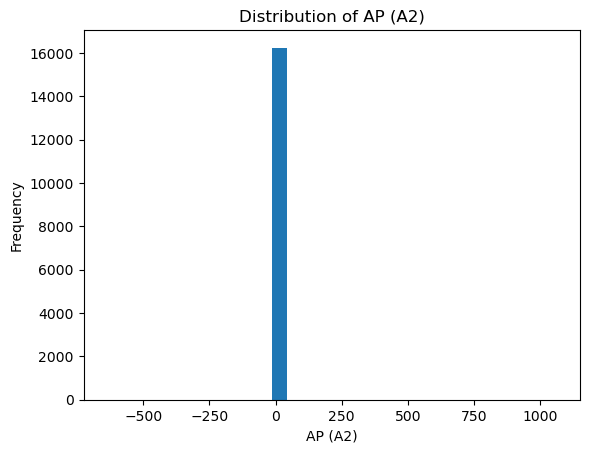

In [18]:
import matplotlib.pyplot as plt

plt.hist(clustering_df["AP (A2)"], bins=30)
plt.xlabel("AP (A2)")
plt.ylabel("Frequency")
plt.title("Distribution of AP (A2)")
plt.show()

In [19]:
print("min AP value :",clustering_df["AP (A2)"].min())
print("max AP value :",clustering_df["AP (A2)"].max())

min AP value : -639.733086415319
max AP value : 1063.9696132234


1. Context and Variability in AP Values

Acidification Potential (AP) as defined by EN 15804+A2 is usually expressed in terms of “Mole of H⁺ equivalents” per functional unit. Because AP depends on many factors such as the specific material, production process, and allocation methods, there isn’t a single, industry‐wide “official” range that applies to all construction products. Instead, published values vary considerably between product types:

Cement-Based Materials and Steel:
For many common materials (e.g., concrete, cement, and steel), AP values are often near zero or within a relatively narrow positive range. It’s not unusual to see values on the order of a few mole H⁺ eq per functional unit (or normalized per kg/m³, m², etc.).

Chemically Intensive or Recycled Materials:
Products that involve complex chemical processing (or where avoided burdens and system credits lead to net “negative” impacts) can report more extreme values. In some cases, values may be negative (indicating net credits) or very high if specific pollutants are significant.

2. What Do the Studies and Databases Show?

While there isn’t a single “official” average, several life cycle assessment (LCA) studies and databases (such as ecoinvent and Ökobaudat) have reported observations along these lines:

For Many Conventional Building Materials:
Research suggests that AP values are often found in a range from roughly –10 to +50 mole H⁺ eq (normalized to a common functional unit). This is typical for products like concrete, steel, and glass.

For Products with Special Treatments or Recycling Credits:
Some studies report AP values that can extend further—for example, values in the range of –50 to +150 mole H⁺ eq have been observed, especially when credits or avoided burdens are included in the assessment.

Note: These numbers are indicative. In the literature, you may also see narrower or wider ranges because of differences in LCA methodology, functional unit definitions, and allocation rules. In some cases, individual datasets may report values (like in your case) ranging from around –600 to +1000, which could reflect a mix of very low (or credited) impacts and outliers for certain material types.

In Summary
There isn’t one “official” average range for AP (A2) in the construction industry due to the wide variability among materials and methodologies. However, many LCA studies and databases suggest that for conventional building products, AP values often lie roughly in the range of –10 to +50 mole H⁺ eq, while more extreme products might fall between –50 and +150 mole H⁺ eq. The dataset’s range (–600 to 1000) indicates that it covers a broad spectrum of products, so it may be useful to use a hybrid, data-driven binning strategy that is also informed by domain knowledge.



When you use scikit-learn’s clustering algorithms like K-Means, they expect the input data to be in a two-dimensional array format where each row represents a sample and each column represents a feature. By default, when you extract a single column from a pandas DataFrame, you get a pandas Series, which is essentially a one-dimensional array with shape (n_samples,). Using .values.reshape(-1, 1) converts that Series into a two-dimensional numpy array with shape (n_samples, 1), which is the format expected by scikit-learn.

For example, if you simply do:

python
Copy
ap_values = df["AP (A2)"]
ap_values is a Series with shape (n_samples,), and K-Means might throw an error because it isn’t a 2D array. In contrast, doing:

python
Copy
ap_values = df["AP (A2)"].values.reshape(-1, 1)
creates an array where each sample is a row and there's one feature (the AP (A2) value) per row.

Using .reshape(-1, 1) tells numpy to infer the number of rows automatically (using -1) and explicitly set the number of columns to 1, ensuring compatibility with scikit-learn’s expectations.

## Data Validation

- The following columns where converted to numeric (float):

"Referenzjahr", "Gueltig bis","Bezugsgroesse", "Bezugseinheit ","Rohdichte (kg/m3)","Flaechengewicht (kg/m2)","Schichtdicke (m)", "Umrechungsfaktor auf 1kg","biogener Kohlenstoffgehalt in kg","biogener Kohlenstoffgehalt (Verpackung) in kg","GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF","PERE", "PERM", "PERT", "PENRE", "PENRM", "PENRT",
"SM", "RSF", "NRSF", "FW", "HWD", "NHWD", "RWD", "CRU", "MFR", "MER", "EEE", "EET",
"AP (A2)", "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
"ETPfw (A2)", "PM (A2)", "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
"HTPc (A2)", "HTPnc (A2)", "IRP (A2)", "SOP (A2)", "ODP (A2)", "POCP (A2)",
"ADPF (A2)", "ADPE (A2)", "WDP (A2)"

- The Konformitat column has been summarized in two categories (A1, A2) in the column "impact_standard"

-  This columns where dropped: "Unnamed: 80", "Unnamed: 79", "URL des Vorgängers","Stueckgewicht (kg)", "Ergiebigkeit (m2)", "Schuettdichte (kg/m3)","Laengengewicht (kg/m)", "Version des Vorgängers"
(These columns have extremely low data coverage and are unlikely to offer analytical value without substantial data imputation or external sourcing. Dropping them will simplify the dataset and reduce noise without significant information loss.)

#REVIEW - Need to decide what to do with missing values! book an appointment with an expert

# EDA

In [20]:
# unique materials/processes in the dataset

print("unique names:",cleaned_df["Name (en)"].nunique()), 
print("unique moduls:",cleaned_df["Modul"].nunique())
print("unique UUID:", cleaned_df["UUID"].nunique())

unique names: 2495
unique moduls: 18
unique UUID: 3863


Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. If you see a reference to a *Process* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

In [21]:
# group by UUID and modul
cleaned_df.groupby(["UUID", "Modul"]).size().reset_index(name="count")

,UUID,Modul,count
0,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,A1-A3,1
1,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,C3,1
2,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,C4,1
3,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,D,1
4,00485255-d8a7-4e6d-b2ab-fba929e3cc4a,A1-A3,1
...,...,...,...
24666,ffeaa284-6f4a-452d-81c9-de28ab3b1dd7,B6,1
24667,ffff2074-fae0-4b5c-b801-af80f5ce633a,A1-A3,1
24668,ffff2074-fae0-4b5c-b801-af80f5ce633a,C2,1
24669,ffff2074-fae0-4b5c-b801-af80f5ce633a,C3,1


Each UUID has entries for different modules (lifecycle phases)

## tBaustoff Dataset

The tBaustoff dataset provides material mapping information with 10 columns. It connects to the ÖKOBAUDAT dataset through process UUIDs and contains end-of-life scenario information for various materials.

End-of-Life Scenarios: Different materials have different potential pathways

- Reuse: Direct application in new construction (highest value retention)
- Recycling: Processing into new material (partial value retention)
- Downcycling: Processing into lower-value applications
- Disposal: Landfilling or incineration (lowest circularity value)

In [22]:
# loading the OBD (combined all years) data and TBS data for further processing
obd_df = cleaned_df.copy()


In [24]:
tbau_df = load_datasets(RAW_DIR / "tBaustoff_with_OBD_mapping.csv")

In [25]:
obd_df.shape

(25665, 76)

In [26]:
tbau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   oekobaudatProcessUuid        728 non-null    object 
 1   oekobaudatDatastockUuid      731 non-null    object 
 2   oekobaudatDatastockName      731 non-null    object 
 3   productId                    815 non-null    int64  
 4   tBaustoffVersion             815 non-null    object 
 5   productName                  815 non-null    object 
 6   eolCategoryId                815 non-null    int64  
 7   eolCategoryName              815 non-null    object 
 8   eolScenarioUnbuiltReal       815 non-null    object 
 9   eolScenarioUnbuiltPotential  815 non-null    object 
 10  technologyFactor             815 non-null    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 70.2+ KB


In [27]:
tbau_df.head(6)

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,3b1f0c75-07a4-4182-b310-5529fc5b54a6,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
1,0dec19c7-53db-4cb9-bbba-4d44d3da62a9,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
2,bd6d6d89-b76d-4002-a217-afffbb8aa308,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
3,fdc99ab8-d843-44ec-a66c-92367d244321,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
4,3feca796-791b-46d3-8160-95ef243ffb9d,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
5,a4c1c27c-53a0-4027-83f6-88c52c758bb1,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,3,2024-Q4,Aluminiumblech,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75


### Data Cleaning

In [28]:
# identifying the columns with missing values
missing_values = tbau_df.isnull().sum()

In [29]:
missing_values

oekobaudatProcessUuid          87
oekobaudatDatastockUuid        84
oekobaudatDatastockName        84
productId                       0
tBaustoffVersion                0
productName                     0
eolCategoryId                   0
eolCategoryName                 0
eolScenarioUnbuiltReal          0
eolScenarioUnbuiltPotential     0
technologyFactor                0
dtype: int64

We have 87 products of tbaustoff that are not in the OKD.
Let's see if we can impute them by trying to find the product name in OKD

In [30]:
missing_name = tbau_df[tbau_df["oekobaudatProcessUuid"].isnull()]
missing_name.head()

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
16,NaN,NaN,NaN,5,2024-Q4,Asphalttragschicht - Hochbau,4,Asphalt (Hochbau),Dep+,CL+,0.75
26,NaN,NaN,NaN,7,2024-Q4,"Balkenschichtholz Nadelholz - unbeschichtet, n...",6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
30,NaN,NaN,NaN,39,2024-Q4,Brettsperrholz,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
31,NaN,NaN,NaN,157,2024-Q4,Konstruktionsvollholz - naturbelassen,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00


In [31]:
# looking for the missing values in the OBD dataframe
missing_obd = obd_df[obd_df["Name (en)"] == "Konstruktionsvollholz - naturbelassen"]
missing_obd

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard


In [32]:
#check duplicated values in tbau_df
duplicated_rows = tbau_df[tbau_df.duplicated()]
print("duplicated rows: ",len(duplicated_rows))

duplicated rows:  0


### Unique Values

In [33]:
obd_uuids = obd_df['UUID'].nunique()
print (obd_uuids, "unique processes in the OBD data")


3863 unique processes in the OBD data


In [34]:
obd_unique_names = obd_df['Name (en)'].nunique()
print(obd_unique_names," unique materials in the OBD data set")


2495  unique materials in the OBD data set


In [35]:
# unique products id 
print(tbau_df["productId"].nunique(), " unique products in the tBaustoff data set")

345  unique products in the tBaustoff data set


We find different processuuid for same products id. This is due to the fact that the uuid of a product changes in each version/year of the OBD (at least in Tbaustoff)

In [36]:
# example for productid 2 (Aluminium Profil) of tbaustoff   
aluminum_2020 = obd_df[obd_df["UUID"] == "bd6d6d89-b76d-4002-a217-afffbb8aa308"]
aluminum_2020[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)", "AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
24562,Aluminium section,2020,D,NaN,NaN,-0.025543,-7.889704
24563,Aluminium section,2020,C2,NaN,NaN,0.000005,0.002553
24564,Aluminium section,2020,C1,NaN,NaN,0.000000,0.000000
24565,Aluminium section,2020,A1-A3,NaN,NaN,0.032528,10.677035


In [37]:
aluminum_2023 = obd_df[obd_df["UUID"] == "fdc99ab8-d843-44ec-a66c-92367d244321"]
aluminum_2023[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)","AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
15297,Aluminium section,2023,A1-A3,0.035951,10.697766,NaN,NaN
15298,Aluminium section,2023,C1,0.000000,0.000000,NaN,NaN
15299,Aluminium section,2023,C2,0.000010,0.003254,NaN,NaN
15300,Aluminium section,2023,D,-0.025415,-7.276583,NaN,NaN


In [38]:
aluminum_2024 = obd_df[obd_df["UUID"] == "3feca796-791b-46d3-8160-95ef243ffb9d"]
aluminum_2024[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)","AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
2254,Aluminium section,2024,A1-A3,0.040735,10.896927,NaN,NaN
2255,Aluminium section,2024,C2,0.000005,0.004260,NaN,NaN
2256,Aluminium section,2024,C3,0.000000,0.000000,NaN,NaN
2257,Aluminium section,2024,D,-0.029156,-7.511520,NaN,NaN


*** same product id linked to 3 different UUID ***

Are the metrics different in different years?
OKD 2020 was working with E 15804 +A1, so is missing all the information of the +A2 columns
There's not much difference between oko 2023 and 2024, at least in the metrics examined, but they are not exactly the same.
Missing values of 2023 or 204 could definitely be imputed with the metrics of the other year. Could have the same approach for year 2020 and previous datasets. 

The total number of actually unique processes in oko is less than expected, given that we can find a same product name with different uuid (depending on the source year). A rough estimate would be to divide the total number of uuids by 3, but not necessarily all processes will be present in all years. 

SUMMARY:

- 345 tbaustoff materials matching with 728 processes of OBD (of which many are same processes but in different version/year). 
- 2619 number of processes in OBD (after removing duplicates for different versions), so missing 1891 to fully match with tbs

In the OBD there are :
- 3863 unique processes (2619 if we consider that some of them are represented with different uuids depending of the version of the dataset)
- 2495  unique materials 

In [39]:
# determining actual unique UUIDS. find rows with same name and modul

# group by name and modul
grouped_df = obd_df.groupby(['Name (en)', 'Modul']).size().reset_index(name='count')

duplicates = grouped_df[grouped_df['count'] > 1]
duplicates

,Name (en),Modul,count
0,1.2.04Expanded clay sand,A1-A3,2
72,3- and 5-layer solid wood panel (German average),A1,2
73,3- and 5-layer solid wood panel (German average),A1-A3,2
74,3- and 5-layer solid wood panel (German average),A2,2
75,3- and 5-layer solid wood panel (German average),A3,2
...,...,...,...
18087,voestalpine rails,D,2
18088,wall elements,A1-A3,2
18089,wall elements,C1,2
18090,wall elements,C2,2


These processes are the actual repeated ones. 

In [40]:
# showing the rows with the same name and modul
obd_df[obd_df["Name (en)"] == "1.2.04Expanded clay sand"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
1495,8ac5659c-5918-41bb-966d-91efdd6c4e50,20.24.070,Blähton Sand,1.2.04Expanded clay sand,'Mineralische Baustoffe' / 'Zuschläge' / 'Bläh...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,1.870000e-12,0.001075,4.812913,2.124977e-08,0.023960,2024,A2
15973,008280d2-302f-4735-b845-1b3af6f14151,20.23.050,Blähton Sand,1.2.04Expanded clay sand,'Mineralische Baustoffe' / 'Zuschläge' / 'Bläh...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,1.595500e-12,0.001071,4.911426,1.548417e-08,0.022202,2023,A2


they both correspond to the same material and process (modul A3), yet they have different UUID (because of the source_year/version). The env metrics are almost the same, but enough to drop them as duplicates? In the next step I will ran a trial to see how it would look like

In [41]:
# Sort by source year descending to keep the latest entry in case of duplicates
obd_df_sorted = obd_df.sort_values(by="source_year", ascending=False)

# Drop duplicates keeping the latest version (based on UUID, Version, Modul)
obd_deduped_df = obd_df_sorted.drop_duplicates(subset=["Name (en)", "Modul"], keep="first") 

# Reset index and show result
obd_deduped_df.reset_index(drop=True, inplace=True)

In [42]:
# write as csv
obd_deduped_df.to_csv(INTERIM_DIR / "obd_merged_deduped.csv", index=False, sep=",", encoding="utf-8")
#NOTE - by removing duplicates, we are losing the information of the different versions of the same material. Right now we are keeping the latest version, but could happen that some of the metrics are only present in the previous versions.

In [43]:
obd_test = obd_df[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)", "AP", "GWP"]]
# filtering for rows with missing values in GWPtotal (A2) and AP is not null
obd_test[obd_test["GWPtotal (A2)"].isna() & obd_test["AP"].notna() & obd_test["AP"] != 0]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
14423,NaN,2024,C1,NaN,NaN,0.002470,0.608000
14424,NaN,2024,C2,NaN,NaN,0.029200,4.980000
14425,NaN,2024,C3,NaN,NaN,0.013500,1.830000
14426,NaN,2024,C4,NaN,NaN,0.025800,4.070000
14427,NaN,2024,D,NaN,NaN,-0.020500,-6.200000
...,...,...,...,...,...,...,...
25655,QNG Electricity grid mix OBD 2020_II,2020,B6,NaN,NaN,0.000628,0.532030
25660,NaN,2020,C4,NaN,NaN,0.007661,81.304757
25662,BauderTHERMOFOL U / M,2020,A5,NaN,NaN,0.000345,0.242000
25663,NaN,2020,A1-A3,NaN,NaN,0.036600,25.100000


In [44]:
print("Number of rows in OBD :", len(obd_df))
print("Number of rows in OBD_deduped :", len(obd_deduped_df))

Number of rows in OBD : 25665
Number of rows in OBD_deduped : 18118


There are 6741 rows that are missing values for A2 metrics (latest version of dataset), but have it in the previous versions. By removing duplicates I'm loosing this values, so we need to assess if we are going to need them later

In [45]:
obd_deduped_df["UUID"].nunique()

2619

In [46]:
obd_deduped_df["Name (en)"].nunique()

2495

In [47]:
obd_deduped_df[obd_deduped_df["Name (en)"] == "Aluminium section"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
2203,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030,2024,A2
2204,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,7.550180e-11,0.027316,131.913039,1.091803e-06,1.610595,2024,A2
2233,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,-4.688030e-11,-0.018711,-87.274090,-6.219902e-07,-1.211407,2024,A2
2234,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2024,A2
14177,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2023,A2


Went from 12 rows to 5, one for each process (instead of nr of processes x number of versions)

In [48]:
obd_deduped_df[obd_deduped_df["Name (en)"] == "Aluminium section"]["Modul"]

2203        C2
2204     A1-A3
2233         D
2234        C3
14177       C1
Name: Modul, dtype: object

In [49]:
obd_df[obd_df["UUID"] == "27f20dc1-5529-4194-8a06-1ae5b7ba6a51"]["Szenario"]

11559              energetisch
11581                      NaN
11582                      NaN
11583                      NaN
11584                      NaN
11585    Entsorgung Verpackung
11586                      NaN
11587                      NaN
Name: Szenario, dtype: object

In [50]:
obd_df[obd_df["Name (en)"] == "Aluminium section"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
2254,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,7.550180e-11,0.027316,131.913039,1.091803e-06,1.610595,2024,A2
2255,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030,2024,A2
2256,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2024,A2
2257,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,...,NaN,NaN,NaN,-4.688030e-11,-0.018711,-87.274090,-6.219902e-07,-1.211407,2024,A2
15297,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,2.064770e-11,0.019711,146.197295,4.722078e-07,0.525069,2023,A2
15298,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2023,A2
15299,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,5.000000e-16,0.000009,0.043828,2.289147e-10,0.000017,2023,A2
15300,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022,...,NaN,NaN,NaN,-4.175700e-12,-0.012814,-97.733143,-2.537972e-07,-0.448489,2023,A2
24562,bd6d6d89-b76d-4002-a217-afffbb8aa308,20.19.120,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','DIN EN 15804',DE,generic dataset,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
24563,bd6d6d89-b76d-4002-a217-afffbb8aa308,20.19.120,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','DIN EN 15804',DE,generic dataset,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


In [51]:
# rows where name is missing
missing_name = obd_df[(obd_df["Name (en)"].isna()) & (obd_df["Name (de)"].isna())]
print ("Number of rows with missing names in english and german:", len(missing_name))

Number of rows with missing names in english and german: 0


The missing rows for names are just for one of the language columns, so they all have names in one language at least

In [52]:
# unique values in the 'OBD' column
tbau_df["oekobaudatProcessUuid"].nunique()

728

In [53]:
len(tbau_df["oekobaudatProcessUuid"])


815

815 - 728  = 87 
Each uuid is unique (not like in obd). The remaining are missing values
Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. Since in the tbaustoff dataset we are talking of *ProcessUuid* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

In [54]:
# looking at the missing values
tbau_df[tbau_df["oekobaudatProcessUuid"].isnull()]

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
16,NaN,NaN,NaN,5,2024-Q4,Asphalttragschicht - Hochbau,4,Asphalt (Hochbau),Dep+,CL+,0.75
26,NaN,NaN,NaN,7,2024-Q4,"Balkenschichtholz Nadelholz - unbeschichtet, n...",6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
30,NaN,NaN,NaN,39,2024-Q4,Brettsperrholz,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
31,NaN,NaN,NaN,157,2024-Q4,Konstruktionsvollholz - naturbelassen,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00
...,...,...,...,...,...,...,...,...,...,...,...
770,NaN,NaN,NaN,286,2024-Q4,"Splitt 2/8, dauerelastisch gebunden (Latex, so...",124,Schüttung organ./min. gebunden,Dep-,Dep-,0.00
771,NaN,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,288,2024-Q4,Splittschüttung mineral. geb.,125,Schüttung min./min. gebunden,RC-,RC-,1.00
772,NaN,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,288,2024-Q4,Splittschüttung mineral. geb.,125,Schüttung min./min. gebunden,RC-,RC-,1.00
773,NaN,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,288,2024-Q4,Splittschüttung mineral. geb.,125,Schüttung min./min. gebunden,RC-,RC-,1.00


| Code   | Likely Meaning                                  |
| ------ | ----------------------------------------------- |
| `EV+`  | Energy recovery with net benefit                |
| `EV-`  | Energy recovery with net loss (e.g., emissions) |
| `RC+`  | Material recycling with positive circularity    |
| `RC-`  | Recycling with limited value recovery           |
| `CL+`  | Closed-loop recycling (same use)                |
| `CL-`  | Closed-loop not feasible                        |
| `Dep+` | Disposal with minor recoverable output          |
| `Dep-` | Full landfill (no recovery)                     |
| `EB`   | End-burning (e.g. incineration)                 |
| `SV`   | Substitutional value or low-grade reuse         |


#REVIEW - in tbaustoff, do different products with same eolcategory share the same eol scenario and technology factor? My hipothesis is that they do, and that's why we can associate them with similar pollutants.

tbau_df[tbau_df["productName"]=="Asphalttragschicht - Hochbau"]

## Removing duplicates of the tbau_df dataframe

In [55]:
# Sort by source year descending to keep the latest entry in case of duplicates
tbs_sorted = tbau_df.sort_values(by="oekobaudatDatastockName", ascending=False)

# Drop duplicates keeping the latest version (based on productName, oekobaudatProcessUuid)
tbs_deduped= tbs_sorted.drop_duplicates(subset=["oekobaudatProcessUuid", "productName"], keep="first")
tbs_deduped = tbs_sorted.drop_duplicates(subset=["productName"], keep="first") 

# Reset index and show result
tbs_deduped.reset_index(drop=True, inplace=True)

In [56]:
tbs_deduped.shape

(338, 11)

In [57]:
tbau_df.shape

(815, 11)

In [58]:
# to CSV
tbs_deduped.to_csv(PROCESSED_DIR/"tbs_deduped.csv", index=False, sep=",", encoding="utf-8")

# Pollutants Dataset

In [59]:
# importing pullutant_combinations.csv
pollutants_df = load_datasets(RAW_DIR / "pollutant_combinations.csv")

In [60]:
pollutants_df

,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,Gussasphaltestrich,Heizungsverteilrohre,S3
3,Beton,ohne Fremd-/Störstoffe,S0
4,Beton,Stahlbewehrung,S2
...,...,...,...
142,"Keramik-, Klinkerplatten, -böden",Kalkmörtel (leicht trennbar),S1
143,"Keramik-, Klinkerplatten, -böden","Kalkzementmörtel, Imprägnierung",S2
144,Glasbaustein,ohne Fremd-/Störstoffe,S0
145,Glasbaustein,Mörtel; Bewehrungsstahl im Mörtel,S2


In [61]:
# unique values in the pollutants_df dataframe
print("Number of unique pollutants in the pollutants_df dataframe:", pollutants_df["Baumaterial ohne Fremd-/Störstoffe"].nunique())

Number of unique pollutants in the pollutants_df dataframe: 66


In [62]:
pollutants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Baumaterial ohne Fremd-/Störstoffe  147 non-null    object
 1   Fremd-/Störstoffbeschreibung        147 non-null    object
 2   Störstoffklasse                     147 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


## Group pollutant categories 

There are many semantically identical or near-identical pollutant descriptions that vary in phrasing. For instance:

All the following under S0 are likely the same:

"ohne Fremd-/Störstoffe"

"ohne Fremd-/Störstoffe (nicht beschichtet, nicht kaschiert)"

"ohne Fremd-/Störstoffe (unbeschichtet oder eloxiert)"

#TODO - predict pollutant class instead of pollutant itself

In [63]:
# Function to correct similar pollutant descriptions
def canonicalize_description(desc):
    if pd.isna(desc):
        return desc
    desc = desc.strip().lower()
    
    if desc.startswith("feinkörn. material"):
        return "feinkörn. Material (Putze, Mörtel); org. Verbind., Bitumenreste, Gips in geringen Mengen (z.B. Feuchteabdichtungen, Spachteln, Anstriche)"
    elif desc.startswith("geringfügig verunreinigt"):
        return "geringfügig verunreinigt (konv. Besch, Klebstoffreste, Belagsreste, Bitumenreste)"
    elif desc.startswith("ohne fremd-/"):
        return "ohne Fremd-/Störstoffe"
    elif desc.startswith("org. v"):
        return "org. V., Bitumen, Gips, Leichtanteile in größeren Mengen (z.B. Gipsputz, Bitumendickschicht, Folien, Flüssigabdichtungen, Dämmstoffreste); Epoxidharz in geringen Mengen (Fugenmassen bei WU Beton, Feuchteabdichtung)"
    elif desc.startswith("heizungsverteilrohre"):
        return "Heizungsverteilrohre; verunreinigt mit Dämmstoff, Kunststoff/Bitumen (Bahnen, Beschichtungen, Flüssigfolie/-abdichtung)"
    elif desc.startswith("klebstof"):
        return "Klebstoff-, Bodenbelagsreste, Trennfolien"
    elif desc in ["lehmfarbe", "lehmputz, lehmfarbe"]:
        return "Lehmputz, Lehmfarbe"
    elif desc.startswith("putze, klebespachtel"):
        return "Putze, Klebespachtel (WDVS), Alukaschierung, Gipskarton"
    elif desc.startswith("verunreinigungen mit natürl."):
        return "Verunreinigungen mit natürl. Materialien (Naturfarbe, Kalkmörtel, Armierungsgewebe)"
    
    return desc  # fallback to unchanged if no match

# Apply the rule-based mapping
pollutants_df["Fremd-/Störstoffbeschreibung"] = pollutants_df["Fremd-/Störstoffbeschreibung"].apply(canonicalize_description)




In [64]:
# Check for unique values in the 'Fremd-/Störstoffbeschreibung' column
unique_values = pollutants_df["Fremd-/Störstoffbeschreibung"].nunique()
print("Number of unique values in 'Fremd-/Störstoffbeschreibung':", unique_values)


Number of unique values in 'Fremd-/Störstoffbeschreibung': 37


## Merging Tbaustoff with Pollutants


In [65]:
# Merge pollutants_df with tbau_df on productName and Baumaterial ohne Fremd-/Störstoffe
merged_df = tbs_deduped.merge(
    pollutants_df,
    left_on="productName",
    right_on="Baumaterial ohne Fremd-/Störstoffe",
    how="inner"
)

# Display the merged dataframe
merged_df

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,Heizungsverteilrohre; verunreinigt mit Dämmsto...,S3
3,fdbe82c6-7073-4f8c-a540-c37a6bf16cd6,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,68,2024-Q4,Expandierter Kork,39,Kork,EV-,RC+,0.75,Expandierter Kork,"putz, klebespachtel, klebstoff",S3
4,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,ohne Fremd-/Störstoffe,S0
5,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,"geringfügig verunreinigt (konv. Besch, Klebsto...",S2
6,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,Heizungsverteilrohre; verunreinigt mit Dämmsto...,S3
7,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,"Lehmputz, Lehmfarbe",S1
8,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,Verunreinigungen mit natürl. Materialien (Natu...,S2
9,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,"konvent. wandfarbe; zement, kalk, gips, kunsts...",S3


Only 15 matches between Tbaustoff and Pollutants datasets